# Problem Statement
<h3>Image Classification</h3></br>
Classifying the given Images into 6 Different Classes i.e.., Categories 
they are :

* Street
* Sea
* Mountain
* Glacier
* Forest
* Buildings


<div>
    <h2>Steps</h2>
    
* Preprocess the dataset
* Explore the dataset
* Train with the Deep neural net with CNN layers
* Train using pre-trained models from keras models
* Classify unseen dataset of images into their respective class and label them

</div>



# Importing Necessary Libraries 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import os
import cv2
from tqdm import tqdm
import PIL
from sklearn.utils import shuffle
from skimage.io import imread, imshow

from tensorflow import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.models import load_model
from tensorflow.keras.utils import to_categorical

import keras.callbacks
from keras.callbacks import ModelCheckpoint
import random
from random import randint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

from keras.applications import vgg16
from keras.preprocessing import image
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Data Loading and Preprocessing

<a id="data"></a>

In [4]:
TrainPath = '../input/intel-image-classification/seg_train/seg_train'
ValidPath = '../input/intel-image-classification/seg_test/seg_test'

In [5]:
#predefined Functions
def image_reader(img_path):
    image = PIL.Image.open(img_path)
    return np.array(image)

def image_function(var,title):
    plt.imshow(var)
    plt.grid('off')
    plt.axis('off')
    plt.title(title)
    
def plot_loss_accuracy(history):

    # create object of arrays of accuracy and loss
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # number of epochs in our model
    epochs = range(1 ,len(acc) + 1)
    
    # call matplolib figure object and plot loss and accuracy curves
    plt.figure(figsize=(15,6))
    
    plt.subplot(121)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title("Training and validation accuracy", fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("accuracy", fontsize=14)
    plt.legend()
    
    plt.subplot(122)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title("Training and validation loss", fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("loss", fontsize=14)
    plt.legend()
    
    plt.show()

In [6]:
PathsDict = {} 
for folder in os.listdir(TrainPath):
    PathsDict[folder] = []

for folder in tqdm(os.listdir(TrainPath)):
    for ImgPath in os.listdir(os.path.join(TrainPath,folder)):
        CompletePath = os.path.join(os.path.join(TrainPath,folder),ImgPath)
        PathsDict[folder].append(CompletePath)

100%|██████████| 6/6 [00:00<00:00,  8.15it/s]


# Exploratory Data Analysis

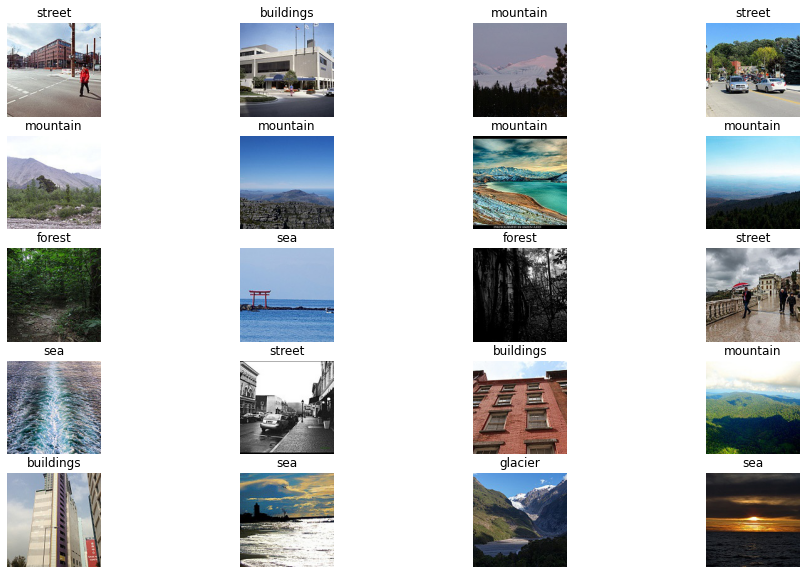

In [7]:
NumberOfFolders = len(PathsDict.keys())
Folders = list(PathsDict.keys())

plt.figure(figsize=(16,10))
for i in range(20):
    ax = plt.subplot(5,4,i+1)
    FolderInd = randint(0,NumberOfFolders)%NumberOfFolders
    CurrentSize = len(PathsDict[Folders[FolderInd]])
    ImgInd= randint(0,CurrentSize)%CurrentSize
    Img = image_reader(PathsDict[Folders[FolderInd]][ImgInd])
    ImgTitle = Folders[FolderInd]
    image_function(Img,ImgTitle)
plt.show()

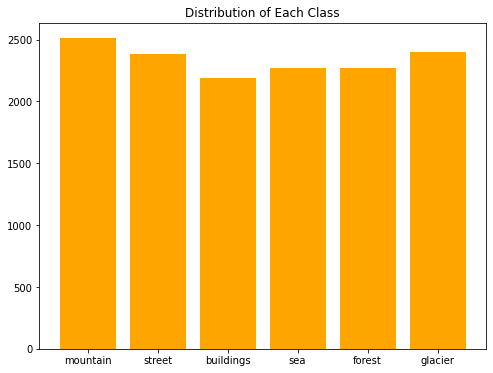

In [8]:
NumOfImages = []
Labels = list(PathsDict.keys())
for label in Labels:
    NumOfImages.append(len(PathsDict[label]))
plt.figure(figsize  = (8,6))
plt.bar(Labels,NumOfImages,color = "Orange")
plt.title("Distribution of Each Class")
plt.show()

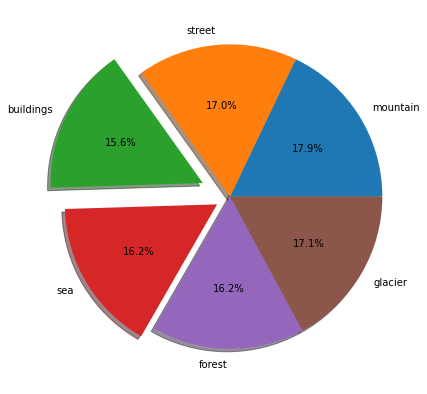

In [9]:

explode = (0.0, 0.0, 0.2, 0.1, 0.0, 0.0)
plt.figure(figsize =(10, 7))
plt.pie(x = NumOfImages,labels = Labels,autopct='%1.1f%%', explode = explode,shadow=True,textprops = dict(color ="black"))
plt.show()

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#ff3700;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
    <h1 style="padding: 10px; color:white; font-weight: bold; font-size : 22px;">
📊Conclusions </h1>
</div>

<div class="alert alert-block alert-info">  
<dl>
<dt style="color: black">📍 All Train Images : </dt>
    <dd>- Number of Images : 14034</dd>
    <dd>- Number of Classes : 6.</dd>
</dl>
</div>

<div class="alert alert-block alert-success">  
<dl>
<dt style="color: black" >📍 All Validtion Images  : </dt>
    <dd>- Number of Images : 3000. </dd>
    <dd>- Number of Classes: 6. </dd>
</dl>
</div>

# Genrating Train and Valid Data

In [10]:
#Creating generator for Train DataSet
TrainDatagen = ImageDataGenerator(
                preprocessing_function=preprocess_input,
                shear_range=0.1,
                zoom_range=0.1,
                horizontal_flip=True)


TrainGenerator = TrainDatagen.flow_from_directory(
                        TrainPath,
                        target_size=(224, 224),
                        batch_size=64,
                        class_mode='categorical')

Found 14034 images belonging to 6 classes.


In [11]:
#Creating generator for Valid DataSet
ValDatagen = ImageDataGenerator(preprocessing_function=preprocess_input)

ValGenerator = ValDatagen.flow_from_directory(
                        ValidPath,
                        target_size=(224, 224),
                        batch_size=64,
                        class_mode='categorical')

Found 3000 images belonging to 6 classes.


# Deep Neural Network Model using CNN Layers

### Feature extraction process of CNN

- The fundamental difference between a densely connected layer and a convolution layer is that, Dense layers learn global patterns in their input feature space, whereas convolution layers learn local patterns by small windows of feature map.

- Feature extraction performed by CNN consists of 3 basic operations.
1. **Filter:** an image for a perticular feature (Convolution)
2. **Detect:** feature within the filtered image (ReLU)
3. **Condense:** image to enhance the features (Maxpooling)

*Ref:* Deep learning with Python by Francois Chollet, [Kaggle learn's Convolution and relu chapter](https://www.kaggle.com/code/ryanholbrook/convolution-and-relu)

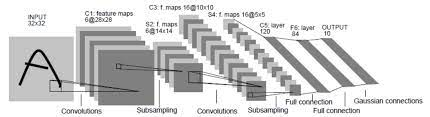

In [12]:
# model architecture of first keras model
model = models.Sequential()
model.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(224,224,3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        3

# Training the Model

In [13]:
#Train the model on new data.
model.compile(
            optimizer=tf.keras.optimizers.Adam(1e-4),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

history=model.fit(
                TrainGenerator,
                epochs = 10,
                validation_data=ValGenerator,
                workers=10,
                use_multiprocessing=True)


Epoch 1/10
220/220 [==============================] - 193s 808ms/step - loss: 1.7170 - accuracy: 0.4803 - val_loss: 1.1982 - val_accuracy: 0.5657
Epoch 2/10
220/220 [==============================] - 187s 809ms/step - loss: 1.0224 - accuracy: 0.6188 - val_loss: 0.9819 - val_accuracy: 0.6480
Epoch 3/10
220/220 [==============================] - 185s 814ms/step - loss: 0.8813 - accuracy: 0.6723 - val_loss: 0.8469 - val_accuracy: 0.6930
Epoch 4/10
220/220 [==============================] - 200s 880ms/step - loss: 0.7949 - accuracy: 0.7061 - val_loss: 0.9330 - val_accuracy: 0.6527
Epoch 5/10
220/220 [==============================] - 181s 795ms/step - loss: 0.7273 - accuracy: 0.7295 - val_loss: 0.7524 - val_accuracy: 0.7333
Epoch 6/10
220/220 [==============================] - 181s 789ms/step - loss: 0.6834 - accuracy: 0.7510 - val_loss: 0.6617 - val_accuracy: 0.7647
Epoch 7/10
220/220 [==============================] - 181s 793ms/step - loss: 0.6483 - accuracy: 0.7662 - val_loss: 0.6725 -

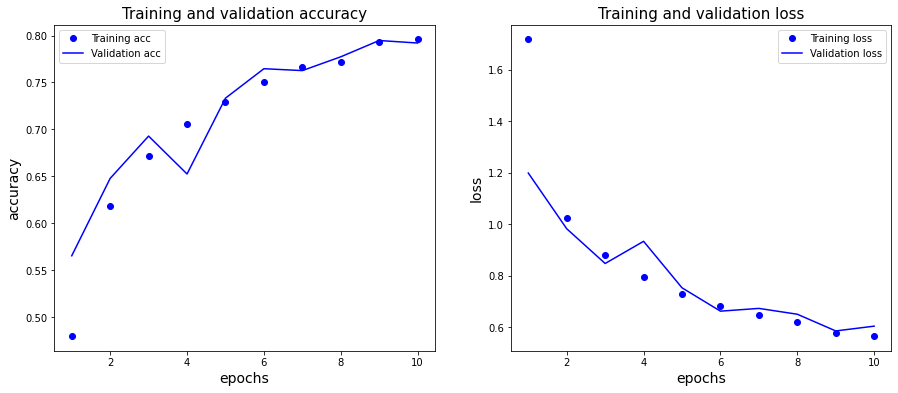

In [14]:
# plotting loss and accuracy curves
plot_loss_accuracy(history)

# Model training using Pre-Trained Convolutional Base VGG16


**VGG16 ARCHITECTURE:**

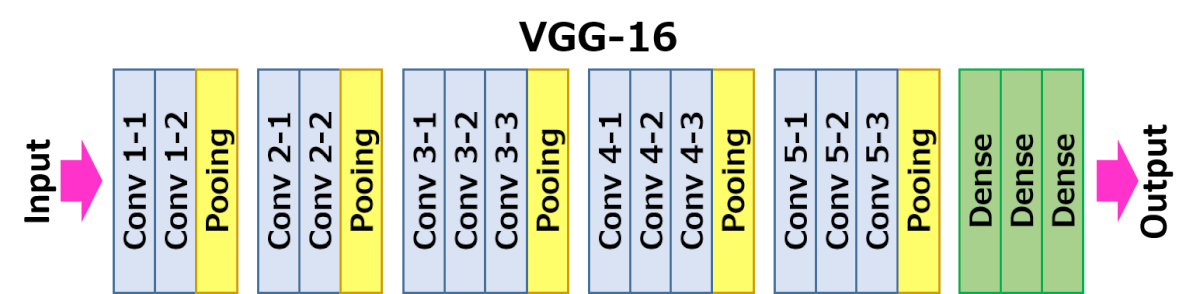

In [15]:
# initializing convolutional base of vgg16
conv_base = vgg16.VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224,224,3)
                 )

conv_base.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [16]:
conv_base.trainable = False

In [17]:
model2=models.Sequential()

model2.add(conv_base)
model2.add(layers.Flatten())

model2.add(layers.Dense(units=4096,activation="relu"))
model2.add(layers.Dense(units=4096,activation="relu"))
model2.add(layers.Dropout(0.4))
model2.add(layers.Dense(units=6, activation="softmax"))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              102764544 
_________________________________________________________________
dense_3 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 24582     
Total params: 134,285,126
Trainable params: 119,570,438
Non-trainable params: 14,714,688
_______________________________

In [18]:
#Train the model on new data.
model2.compile(
            optimizer=tf.keras.optimizers.Adam(1e-4),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

history=model2.fit(
                TrainGenerator,
                epochs = 10,
                validation_data=ValGenerator,
                workers=10,
                use_multiprocessing=True)

Epoch 1/10
220/220 [==============================] - 199s 848ms/step - loss: 1.6233 - accuracy: 0.8574 - val_loss: 0.6858 - val_accuracy: 0.8997
Epoch 2/10
220/220 [==============================] - 206s 906ms/step - loss: 0.4757 - accuracy: 0.9136 - val_loss: 0.5233 - val_accuracy: 0.9110
Epoch 3/10
220/220 [==============================] - 187s 822ms/step - loss: 0.2770 - accuracy: 0.9372 - val_loss: 0.5046 - val_accuracy: 0.9090
Epoch 4/10
220/220 [==============================] - 187s 818ms/step - loss: 0.2070 - accuracy: 0.9488 - val_loss: 0.5367 - val_accuracy: 0.9183
Epoch 5/10
220/220 [==============================] - 187s 822ms/step - loss: 0.1492 - accuracy: 0.9620 - val_loss: 0.5184 - val_accuracy: 0.9200
Epoch 6/10
220/220 [==============================] - 206s 908ms/step - loss: 0.1135 - accuracy: 0.9676 - val_loss: 0.5254 - val_accuracy: 0.9140
Epoch 7/10
220/220 [==============================] - 186s 815ms/step - loss: 0.1214 - accuracy: 0.9690 - val_loss: 0.5743 -

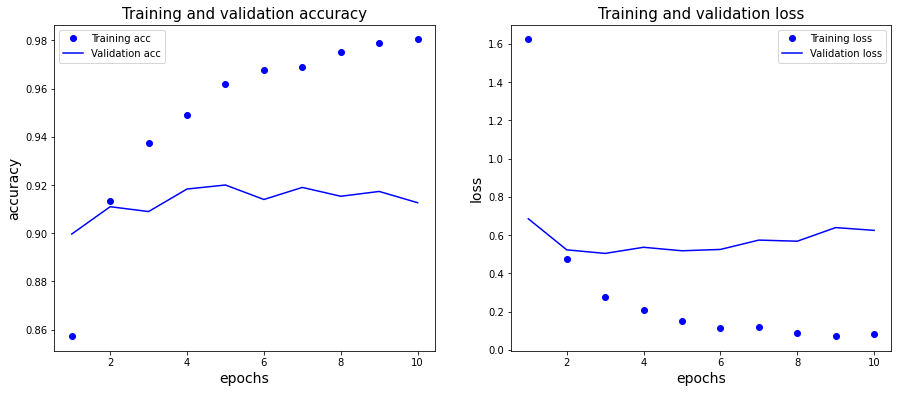

In [19]:
# plotting loss and accuracy curves
plot_loss_accuracy(history)

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#ff3700;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
    <h1 style="padding: 10px; color:white; font-weight: bold; font-size : 22px;">
📊Conclusions </h1>
</div>

# Accuracy 
- Accuracy is the Classification metric here since all classes are divided Equally

<div class="alert alert-block alert-info">  
<dl>
<dt style="color: black">📍 Model 1 Accuracy : </dt>
    <dd>- Accuracy: 79.5</dd>
</dl>
</div>

<div class="alert alert-block alert-success">  
<dl>
<dt style="color: black" >📍 Model2 Accuracy  : </dt>
    <dd>- Accuracy: 98.3. </dd>
</dl>
</div>